In [1]:
# import lib
import pandas as pd
import numpy as np

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('D:/project_data_mining/src/dataset.csv')

In [3]:
# encode category 
df["cat_id"] = df["Expenditure_category"].astype("category").cat.codes


In [4]:
# lag features
def create_lag_features(df):
    df = df.copy()

    for lag in [1, 3, 6, 12]:
        df[f"CPI_lag_{lag}"] = (
            df.groupby("Expenditure_category")["CPI"].shift(lag)
        )

    for lag in [1, 3]:
        df[f"Energy_lag_{lag}"] = (
            df.groupby("Expenditure_category")["Energy"].shift(lag)
        )

    df["GDP_lag_1"] = (
        df.groupby("Expenditure_category")["GDP"].shift(1)
    )

    return df


In [5]:
# rolling
def create_rolling_features(df):
    df = df.copy()

    df["CPI_roll_mean_3"] = (
        df.groupby("Expenditure_category")["CPI"]
          .shift(1)
          .rolling(3)
          .mean()
    )

    df["CPI_roll_std_6"] = (
        df.groupby("Expenditure_category")["CPI"]
          .shift(1)
          .rolling(6)
          .std()
    )

    return df


In [6]:
df = create_lag_features(df)
df = create_rolling_features(df)

# Drop NaN sinh ra do lag/rolling
df_ml = df.dropna().reset_index(drop=True)

In [ ]:
# # split train/val/test 
train_df = df[(df["TIME_PERIOD"] >= "2011-01-01") & (df["TIME_PERIOD"] <= "2020-12-31")]
val_df   = df[(df["TIME_PERIOD"] >= "2021-01-01") & (df["TIME_PERIOD"] <= "2022-12-31")]
test_df  = df[(df["TIME_PERIOD"] >= "2023-01-01") & (df["TIME_PERIOD"] <= "2025-12-31")]

In [8]:
# feature set 
features = [
    "cat_id",
    "CPI_lag_1", "CPI_lag_3", "CPI_lag_6", "CPI_lag_12",
    "Energy_lag_1", "Energy_lag_3",
    "GDP_lag_1",
    "CPI_roll_mean_3",
    "CPI_roll_std_6"
]

X_train = train_df[features]
y_train = train_df["CPI"]

X_val = val_df[features]
y_val = val_df["CPI"]

X_test = test_df[features]
y_test = test_df["CPI"]


In [ ]:
# train
xgb= XGBRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# train
xgb.fit(X_train, y_train)


d:\project_data_mining\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:22:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
# eval
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    ) * 100

def pred_within_10pct(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true <= 0.10) * 100

def evaluate_global(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    smp  = smape(y_true, y_pred)
    p10  = pred_within_10pct(y_true, y_pred)

    print(f"\n{name} (GLOBAL MODEL)")
    print(f"RMSE       : {rmse:.3f}")
    print(f"MAE        : {mae:.3f}")
    print(f"sMAPE      : {smp:.2f}%")
    print(f"Pred <10%  : {p10:.2f}%")


In [11]:
# results
val_pred  = xgb.predict(X_val)
test_pred = xgb.predict(X_test)

evaluate_global(y_val,  val_pred,  "Validation")
evaluate_global(y_test, test_pred, "Test")



Validation (GLOBAL MODEL)
RMSE       : 1.115
MAE        : 0.719
sMAPE      : 0.79%
Pred <10%  : 100.00%

Test (GLOBAL MODEL)
RMSE       : 1.263
MAE        : 1.017
sMAPE      : 1.02%
Pred <10%  : 100.00%


In [12]:
# CPI actual - CPI predict 
results_test = test_df[[
    "TIME_PERIOD",
    "Expenditure_category",
    "CPI"
]].copy()

results_test["CPI_pred_XGB"] = test_pred

results_test.head()

,TIME_PERIOD,Expenditure_category,CPI,CPI_pred_XGB
156,2025-01-01,All Items,99.908,99.556168
157,2025-02-01,All Items,100.677,99.545677
158,2025-03-01,All Items,100.599,99.773239
159,2025-04-01,All Items,100.283,99.623940
160,2025-05-01,All Items,100.978,99.902130


In [13]:
# vis
def plot_global_results(df, n_cat=6):
    cats = df["Expenditure_category"].unique()[:n_cat]

    for cat in cats:
        d = df[df["Expenditure_category"] == cat]

        plt.figure(figsize=(10,4))
        plt.plot(d["TIME_PERIOD"], d["CPI"], label="Actual")
        plt.plot(d["TIME_PERIOD"], d["CPI_pred_XGB"], label="XGB")
        plt.title(cat)
        plt.legend()
        plt.grid(True)
        plt.show()


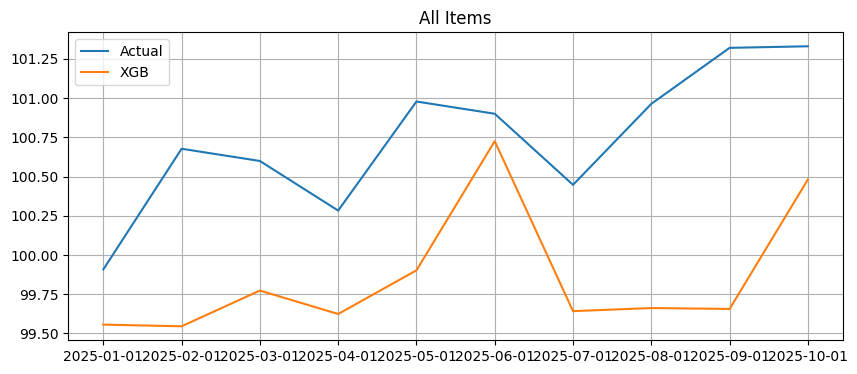

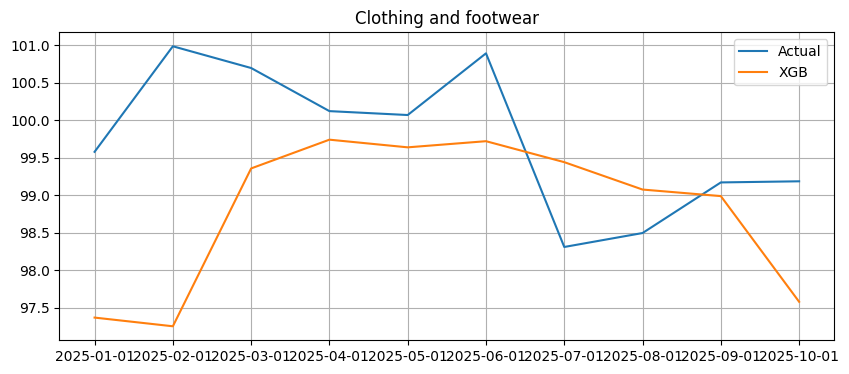

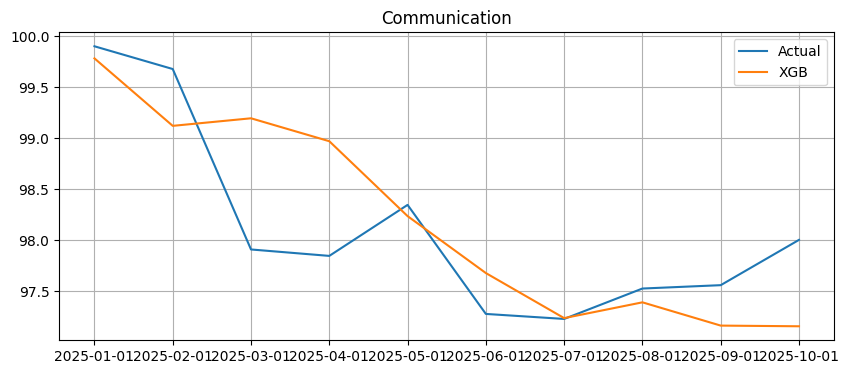

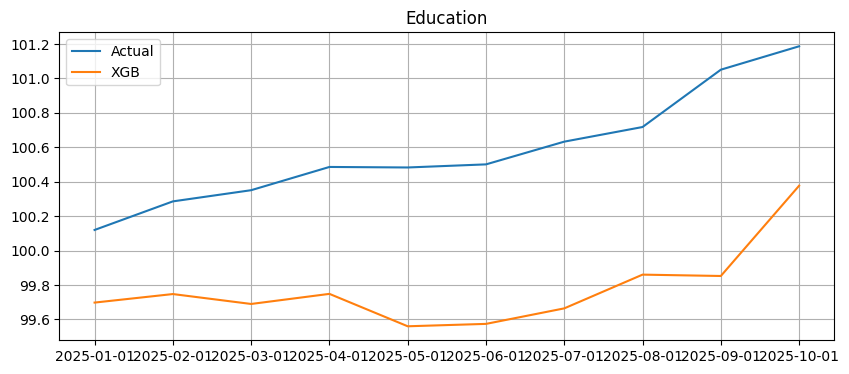

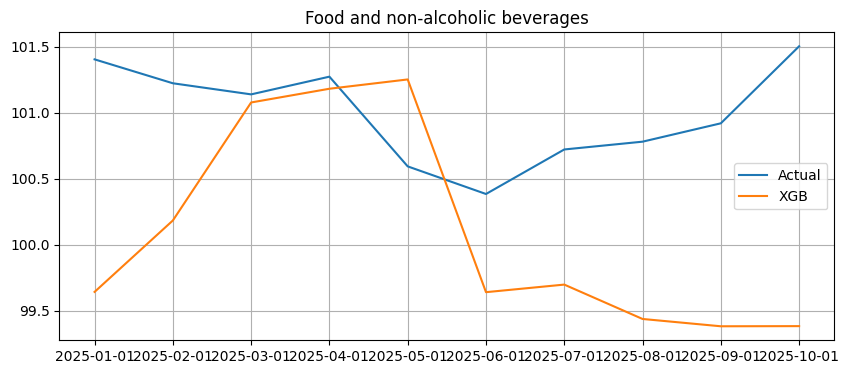

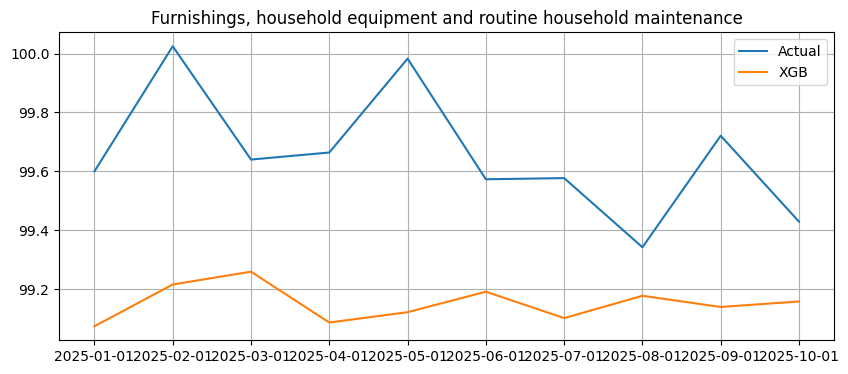

In [14]:
plot_global_results(results_test)
